In [16]:
text = 'You say goodbye and I say hello.'

In [17]:
text = text.lower()

In [18]:
print(text)

you say goodbye and i say hello.


In [19]:
text = text.replace('.', ' .')

In [20]:
print(text)

you say goodbye and i say hello .


In [21]:
words = text.split(' ')

In [22]:
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [23]:
word_to_id={}
id_to_word={}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word]=new_id
        id_to_word[new_id]=word

In [24]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [25]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [26]:
word_to_id['.']

6

In [27]:
id_to_word[1]

'say'

In [28]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [29]:
#前処理(単語リストから単語IDへ変換)関数

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id={}
    id_to_word={}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word

    corpus = [word_to_id[w] for w in words]
    corpus = np.array(corpus)

    return corpus, word_to_id, id_to_word

In [30]:
#  共起行列
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [31]:
# 自動化ベクター:共起行列作成
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size= len(corpus)
    co_martix=np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size +1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
                
            if right_idx < corpus_size:
                right_word_id =corpus[right_idx]
                co_matrix[word_id, right_word_id] +=1
                
    return co_martix

In [32]:
#  similarity 
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size=len(word_to_id)
C=create_co_matrix(corpus, vocab_size)

c0=C[word_to_id['you']]
c1=C[word_to_id['i']]

print(cos_similarity(c0, c1))


0.7071067691154799


In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    #Query を取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('\n[query]' + query)
    query_id =word_to_id[query]
    query_vec=word_matrix[query_id]
    
    #Cosign類似度をだす
    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i]=cos_similarity(word_matrix[i], query_vec)
        
    #Cosign類似度の結果より、値を高い順に出力
    count=0
    for i in (-1 * similarity).argsort():
        if id_to_word[i]==query:
            continue
        print('%s: %s' %(id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:

            
            return

In [34]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size=len(word_to_id)
C=create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)




[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [35]:
def ppmi (C, verbose=False, eps=1e-8):
    M=np.zeros_like(C, dtype=np.float32)
    N=np.sum(C)
    S=np.sum(C, axis=0)
    total=C.shape[0]*C.shape[1]
    cnt=0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i, j]*N/(S[j]*S[i])+eps)
            M[i, j]=max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100)==0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [36]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
C=create_co_matrix(corpus, vocab_size)
W=ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('_'*50)
print('ppmi')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
__________________________________________________
ppmi
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [50]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size=len(word_to_id)
C=create_co_matrix(corpus, vocab_size)
W=ppmi(C)

U, S, V =np.linalg.svd(W)

In [51]:
print(C[0])

[0 1 0 0 0 0 0]


In [52]:
print(W[0])

[0.    1.807 0.    0.    0.    0.    0.   ]


In [53]:
print(U[0])

[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]


# 特異値分解は逆行列をやってる

In [41]:
#A = np.array([[1,2],[3,4]])

In [42]:
#U, s, V = np.linalg.svd(A, full_matrices=True)

## 中身のチェックをする

In [43]:
#U

array([[-0.576, -0.817],
       [ 0.817, -0.576]])

In [44]:
#s

array([5.465, 0.366])

In [45]:
#V

array([[-0.576, -0.817],
       [ 0.817, -0.576]])

In [46]:
#対角成分
#np.diag(s)

array([[5.465, 0.   ],
       [0.   , 0.366]])

In [47]:
#元に戻るか確認してみる
#np.dot(np.dot(U, np.diag(s)),V)

array([[1., 2.],
       [3., 4.]])

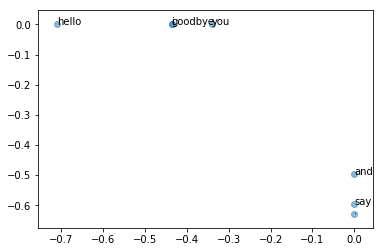

In [54]:
# グラフプロット
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()